In [1]:
def merge_entities(doc):
    """Preprocess a spaCy doc, merging entities into a single token.
    Best used with nlp.add_pipe(merge_entities).

    doc (spacy.tokens.Doc): The Doc object.
    RETURNS (Doc): The Doc object with merged noun entities.
    """
    spans = [(e.start_char, e.end_char, e.root.tag, e.root.dep, e.label)
             for e in doc.ents]
    for start, end, tag, dep, ent_type in spans:
        doc.merge(start, end, tag=tag, dep=dep, ent_type=ent_type)
    return doc

In [2]:
import dateparser as dp
import string
exclude = set(string.punctuation)

# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline


import spacy
from spacy_hunspell import spaCyHunSpell

# load nlp parser with spellchecker
nlp = spacy.load('en')
hunspell = spaCyHunSpell(nlp, ('./src/hunspell/en_US.dic', './src/hunspell/en_US.aff'))

nlp.add_pipe(hunspell)
nlp.add_pipe(merge_entities, name='merge_entities')

In [3]:
import networkx as nx

In [4]:
def tokenize(sentence):
    tokenized_sentence = []
    for token in sentence.split(' '): # simplest split is
        token = ''.join(ch for ch in token if ch not in exclude)
        if token != '':
            tokenized_sentence.append(token.lower())
    return ' '.join(tokenized_sentence)

In [5]:
def correction_spacy(parsed):
    corrected = []
    for w in parsed.doc:
        if not(w._.hunspell_spell):
            corrected.append(str(w._.hunspell_suggest[0]))
        else:
            corrected.append(str(w))
    return nlp(' '.join(corrected))

In [6]:
def get_date_sentence(sentence):
    date_in_sentence = []
    for entity in sentence.ents:
        if entity.label_=="DATE":
            date_in_sentence.append(entity.text)
    return date_in_sentence

In [7]:
# Date extraction
def time_convert(list_str_date):
    return [dp.parse(w) for w in list_str_date]


In [32]:
def get_attr(sentence, attribut):
    nsubj = []
    for token in sentence:
        if token.dep_ == attribut:
            nsubj.append(token)
    return nsubj

In [64]:
def get_pos(sentence, pos):
    nsubj = []
    for token in sentence:
        # print(token.text, token.pos_, token.dep_)
        if token.pos_ == pos:
            nsubj.append(token)
    return nsubj

In [26]:
def get_dep_graph(document):
    edges = []
    for token in document:
        # FYI https://spacy.io/docs/api/token
        for child in token.children:
            edges.append(('{0}'.format(token),
                          '{0}'.format(child)))

    return nx.Graph(edges)


In [140]:
def get_closest_relation(graph, first_class, second_class):
    paths =[[(elt2.text, elt1) for elt2 in second_class ] for elt1 in first_class]
    lengths =[[nx.shortest_path_length(graph, source=subj.text, target=date) for subj in second_class ] for date in first_class]
    
    index_min = [np.argmin(length) for length in lengths]
    subject_date = []
    for i, date in enumerate(first_class):
        subject_date.append(paths[i][index_min[i]])

    return subject_date

In [46]:
def word_is_negated(word):
    """ """

    for child in word.children:
        if child.dep_ == 'neg':
            return True

    if word.pos_ in {'VERB'}:
        for ancestor in word.ancestors:
            if ancestor.pos_ in {'VERB'}:
                for child2 in ancestor.children:
                    if child2.dep_ == 'neg':
                        return True

    return False

def find_negated_wordSentIdxs_in_sent(sent, idxs_of_interest=None):
    """ """

    negated_word_idxs = set()
    for word_sent_idx, word in enumerate(sent):
        if idxs_of_interest:
            if word_sent_idx not in idxs_of_interest:
                continue
        if word_is_negated(word):
            negated_word_idxs.add(word_sent_idx)

    return negated_word_idxs

In [79]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [19]:
input_text = "This is a test text, which mean i am unavalable the 24th of februry, and also tomorrow. But John will not be here tuesday"

In [20]:
## First Task, cleaning Data

input_text = tokenize(input_text)

print(input_text)

this is a test text which mean i am unavalable the 24th of februry and also tomorrow but john will not be here tuesday


In [21]:
## Next, the text is parse with nlp from Spacy
parsed = nlp(input_text)

In [22]:
# Spellcheck
corrected = correction_spacy(parsed)
print(corrected)

this is a test text which mean i am unavailable the 24th of February and also tomorrow but john will not be here Tuesday


In [23]:
# Date extraction
dates_str = get_date_sentence(corrected)
print(dates_str)

['the 24th of February', 'tomorrow', 'Tuesday']


In [24]:
# Date conversion
dates = time_convert(dates_str)
print(dates)

[datetime.datetime(2019, 2, 24, 0, 0), datetime.datetime(2019, 1, 28, 0, 48, 40, 988365), datetime.datetime(2019, 1, 22, 0, 0)]


In [65]:
# nsubj extraction 
nsubj = get_attr(corrected, "nsubj")
negs = get_attr(corrected, "neg")
verbs = get_pos(corrected, "VERB")
print(nsubj)
print(negs)
print(verbs)

[this, which, i, john]
[not]
[is, mean, am, will, be]


[('i', 'the 24th of February'), ('i', 'tomorrow'), ('john', 'Tuesday')]
[('am', 'the 24th of February'), ('am', 'tomorrow'), ('be', 'Tuesday')]


/home/froux/anaconda3/envs/hack/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


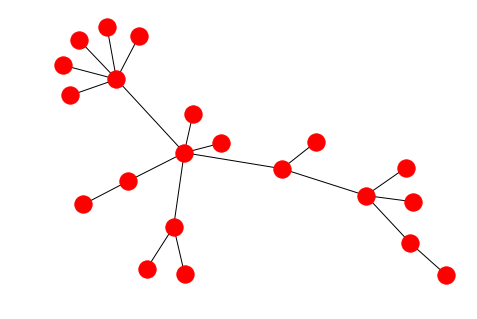

In [45]:
graph = get_dep_graph(corrected)
nx.draw(graph)
subj_date = get_closest_relation(graph, dates_str, nsubj)
verb_date = get_closest_relation(graph, dates_str, verbs)
print(subj_date)
print(verb_date)

In [62]:
negatives = [corrected[negate].text for negate in find_negated_wordSentIdxs_in_sent(corrected)]
print(negatives)

negative_time = [item[1] for item in verb_date if item[0] in negatives]
positive_time = [item[1] for item in verb_date if not(item[0] in negatives)]
print("positive", positive_time)
print("negative", negative_time)

print(time_convert(positive_time))
print(time_convert(negative_time))

['will', 'be']
positive ['the 24th of February', 'tomorrow']
negative ['Tuesday']
[datetime.datetime(2019, 2, 24, 0, 0), datetime.datetime(2019, 1, 28, 1, 24, 46, 75531)]
[datetime.datetime(2019, 1, 22, 0, 0)]


In [158]:
def extract(input_text):
    ## First Task, simple cleaning for preparing proper tokenize
    # input_text = tokenize(input_text)
    
    ## Next, the text is parse with nlp from Spacy
    parsed = nlp(input_text)
    corrected = correction_spacy(parsed)
    pos = []
    neg = []
    for sentence in corrected.sents:
        print(" ")
        print(sentence.text)
        # Spellcheck
        parse_sent = nlp(sentence.text)
        # Date extraction (as string)
        dates_str = get_date_sentence(parse_sent)
        # Extraction of subject and verbs (as token)
        subjects = get_attr(parse_sent, "nsubj")
        verbs = get_pos(parse_sent, "VERB")

        # Get the graphs of dependancy (as nx graphs)
        graph = get_dep_graph(parse_sent)
        # Get the closest subjects and verbs
        subj_date = get_closest_relation(graph, dates_str, subjects)
        verb_date = get_closest_relation(graph, dates_str, verbs)
        # Get all the negatives terms of the sentences
        negatives = [parse_sent[negate].text for negate in find_negated_wordSentIdxs_in_sent(parse_sent)]
        print("negative word of the sentences: ", negatives)

        negative_time = [item[1] for item in verb_date if (item[0] in negatives or item[1] in negatives)]
        positive_time = [item[1] for item in verb_date if not(item[1] in negative_time)]

        neg += [ (key[0], dp.parse(key[1])) for key in subj_date if key[1] in negative_time]
        pos += [ (key[0], dp.parse(key[1])) for key in subj_date if key[1] in positive_time]
        
    return pos, neg

In [99]:
input_text = "This is a test text. which mean i am unavalable the 25th of februry, and also tomorrow. But John will not be here tuesday. Mary may be there frifay, but not wednesday"

In [160]:
print(input_text)
print("")
extraction_pos, extraction_neg = extract(input_text)
print(" ")
print("positive time and personne associated")
for item in extraction_pos:
    print(item)

print("negative time and personne associated")
for item in extraction_neg:
    print(item)

This is a test text. which mean i am unavalable the 25th of februry, and also tomorrow. But John will not be here tuesday. Mary may be there frifay, but not wednesday

 
This is a test text .
negative word of the sentences:  []
 
which mean i am unavailable the 25th of February e and also tomorrow .
negative word of the sentences:  []
 
But John will not be here Tuesday .
negative word of the sentences:  ['will', 'be']
 
Mary may be there Friday e but not Wednesday
negative word of the sentences:  ['Wednesday']
 
positive time and personne associated
('i', datetime.datetime(2019, 2, 25, 0, 0))
('i', datetime.datetime(2019, 1, 28, 2, 13, 33, 704676))
('Mary', datetime.datetime(2019, 1, 25, 0, 0))
negative time and personne associated
('John', datetime.datetime(2019, 1, 22, 0, 0))
('Mary', datetime.datetime(2019, 1, 23, 0, 0))
